In [24]:
import numpy as np
import pandas as pd
from tabulate import tabulate
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [8]:
import pymysql
from sqlalchemy import create_engine
username = 'adan'
password = 'adan'
host_port = '35.194.136.165:3306'
database = 'twfruits'

In [10]:
import pandas as pd       
# 建立連線
engine = create_engine("mysql+pymysql://{}:{}@{}/{}".format(username, password, host_port, database))
con = engine.connect()
# pd.read_sql(table名稱, 連線資訊)
df = pd.read_sql('banana_台北二', engine)
# 關閉連線
con.close

<bound method Connection.close of <sqlalchemy.engine.base.Connection object at 0x00000270FD84D880>>

In [27]:
from pandas import Series

df = df[["日期","banana_平均價"]]
df

,日期,banana_平均價
0,2011-01-01,31.4
1,2011-01-02,32.0
2,2011-01-03,32.2
3,2011-01-04,32.4
4,2011-01-05,33.2
...,...,...
3866,2021-08-02,37.7
3867,2021-08-03,35.2
3868,2021-08-04,37.9
3869,2021-08-05,40.7


In [29]:
#儲存日期
date_orginal = df["日期"]
date_orginal

0      2011-01-01
1      2011-01-02
2      2011-01-03
3      2011-01-04
4      2011-01-05
          ...    
3866   2021-08-02
3867   2021-08-03
3868   2021-08-04
3869   2021-08-05
3870   2021-08-06
Name: 日期, Length: 3871, dtype: datetime64[ns]

In [ ]:
df['日期'] = pd.to_datetime(df['日期'])
df = df.set_index(['日期'], drop=True)

In [33]:
df.head(5)

,banana_平均價
日期,
2011-01-01,31.4
2011-01-02,32.0
2011-01-03,32.2
2011-01-04,32.4
2011-01-05,33.2


<AxesSubplot:xlabel='日期'>

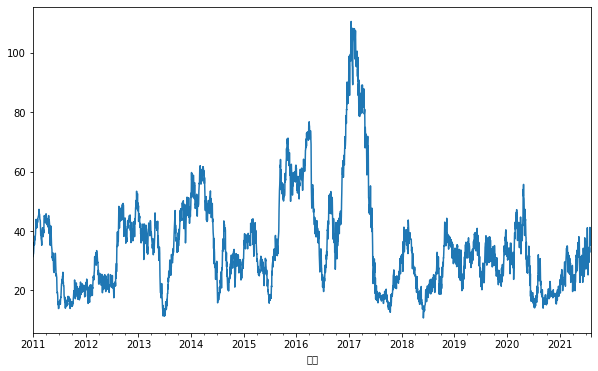

In [35]:
plt.figure(figsize=(10, 6))

df['banana_平均價'].plot()

In [37]:
#單根檢定
#評斷標準:(1)ADF統計值 < 臨界值 (2) **p-value < 0.05
result = adfuller(df['banana_平均價'])
print('p-value: {}'.format(round(result[1],4)))
#結果 : 小於顯著水準，拒絕虛無假設 → 資料為定態

p-value: 0.0063


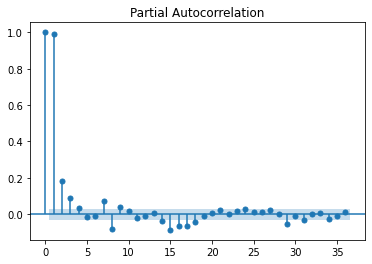

In [39]:
#挑選p參數，透過偏自相關函數圖PACF圖
plot_pacf(df)
plt.show()

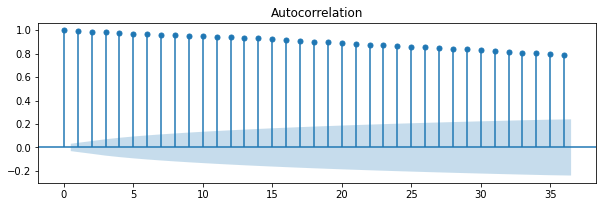

In [40]:
#挑選q參數透過自相關函數圖ACF圖
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(311)
# fig = plot_acf(data)
fig = plot_acf(df, ax=ax1, title="Autocorrelation")

In [41]:
import pmdarima as pm
model_fit = pm.auto_arima(df.banana_平均價, start_p=1, start_q=1,
                      information_criterion='aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=17002.913, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=39353.240, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=34305.430, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16995.430, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=16996.300, Time=0.69 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=16996.544, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16994.544, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=30498.721, Time=0.47 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=16996.545, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=27465.186, Time=0.53 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=16993.350, Time=0.53 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=16973.806, Time=0.98 sec
 ARIMA(3,0,2)(0,0,0)[0]        

In [56]:
model = ARIMA(df, order=(3, 0, 3))
results = model.fit()
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:             banana_平均價   No. Observations:                 3871
Model:                     ARMA(3, 3)   Log Likelihood               -8474.772
Method:                       css-mle   S.D. of innovations              2.159
Date:                Mon, 09 Aug 2021   AIC                          16965.543
Time:                        00:36:16   BIC                          17015.634
Sample:                    01-01-2011   HQIC                         16983.329
                         - 08-06-2021                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               35.2211      4.933      7.140      0.000      25.553      44.889
ar.L1.banana_平均價     0.1263      0.110      1.151      0.250      -0.089       0.341
ar.L2.banana_平均價     0.0894 

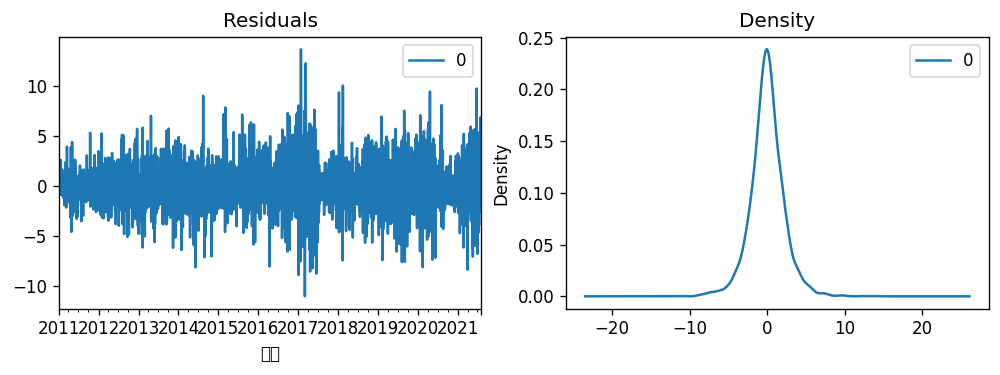

In [57]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [61]:
#將日期index刪除,改為數字
test = df.banana_平均價[-30:]
test_2 = test
test_2 = test_2.reset_index(drop=True)
test_2

0     36.0
1     36.7
2     37.7
3     41.1
4     36.9
5     32.6
6     30.8
7     28.0
8     25.2
9     27.0
10    32.7
11    31.7
12    30.6
13    32.1
14    34.5
15    31.8
16    29.5
17    34.4
18    33.6
19    32.8
20    34.3
21    41.2
22    37.3
23    37.6
24    40.2
25    37.7
26    35.2
27    37.9
28    40.7
29    38.3
Name: banana_平均價, dtype: float64

[35.09739915 35.01287531 35.01601481 35.01913471 35.01945121 35.01954525
 35.01971038 35.01988742 35.02006229 35.02023577 35.02040839 35.02058015
 35.02075105 35.02092109 35.02109028 35.02125862 35.02142612 35.02159277
 35.02175859 35.02192357 35.02208772 35.02225106 35.02241357 35.02257526
 35.02273615 35.02289622 35.02305549 35.02321397 35.02337164 35.02352853]


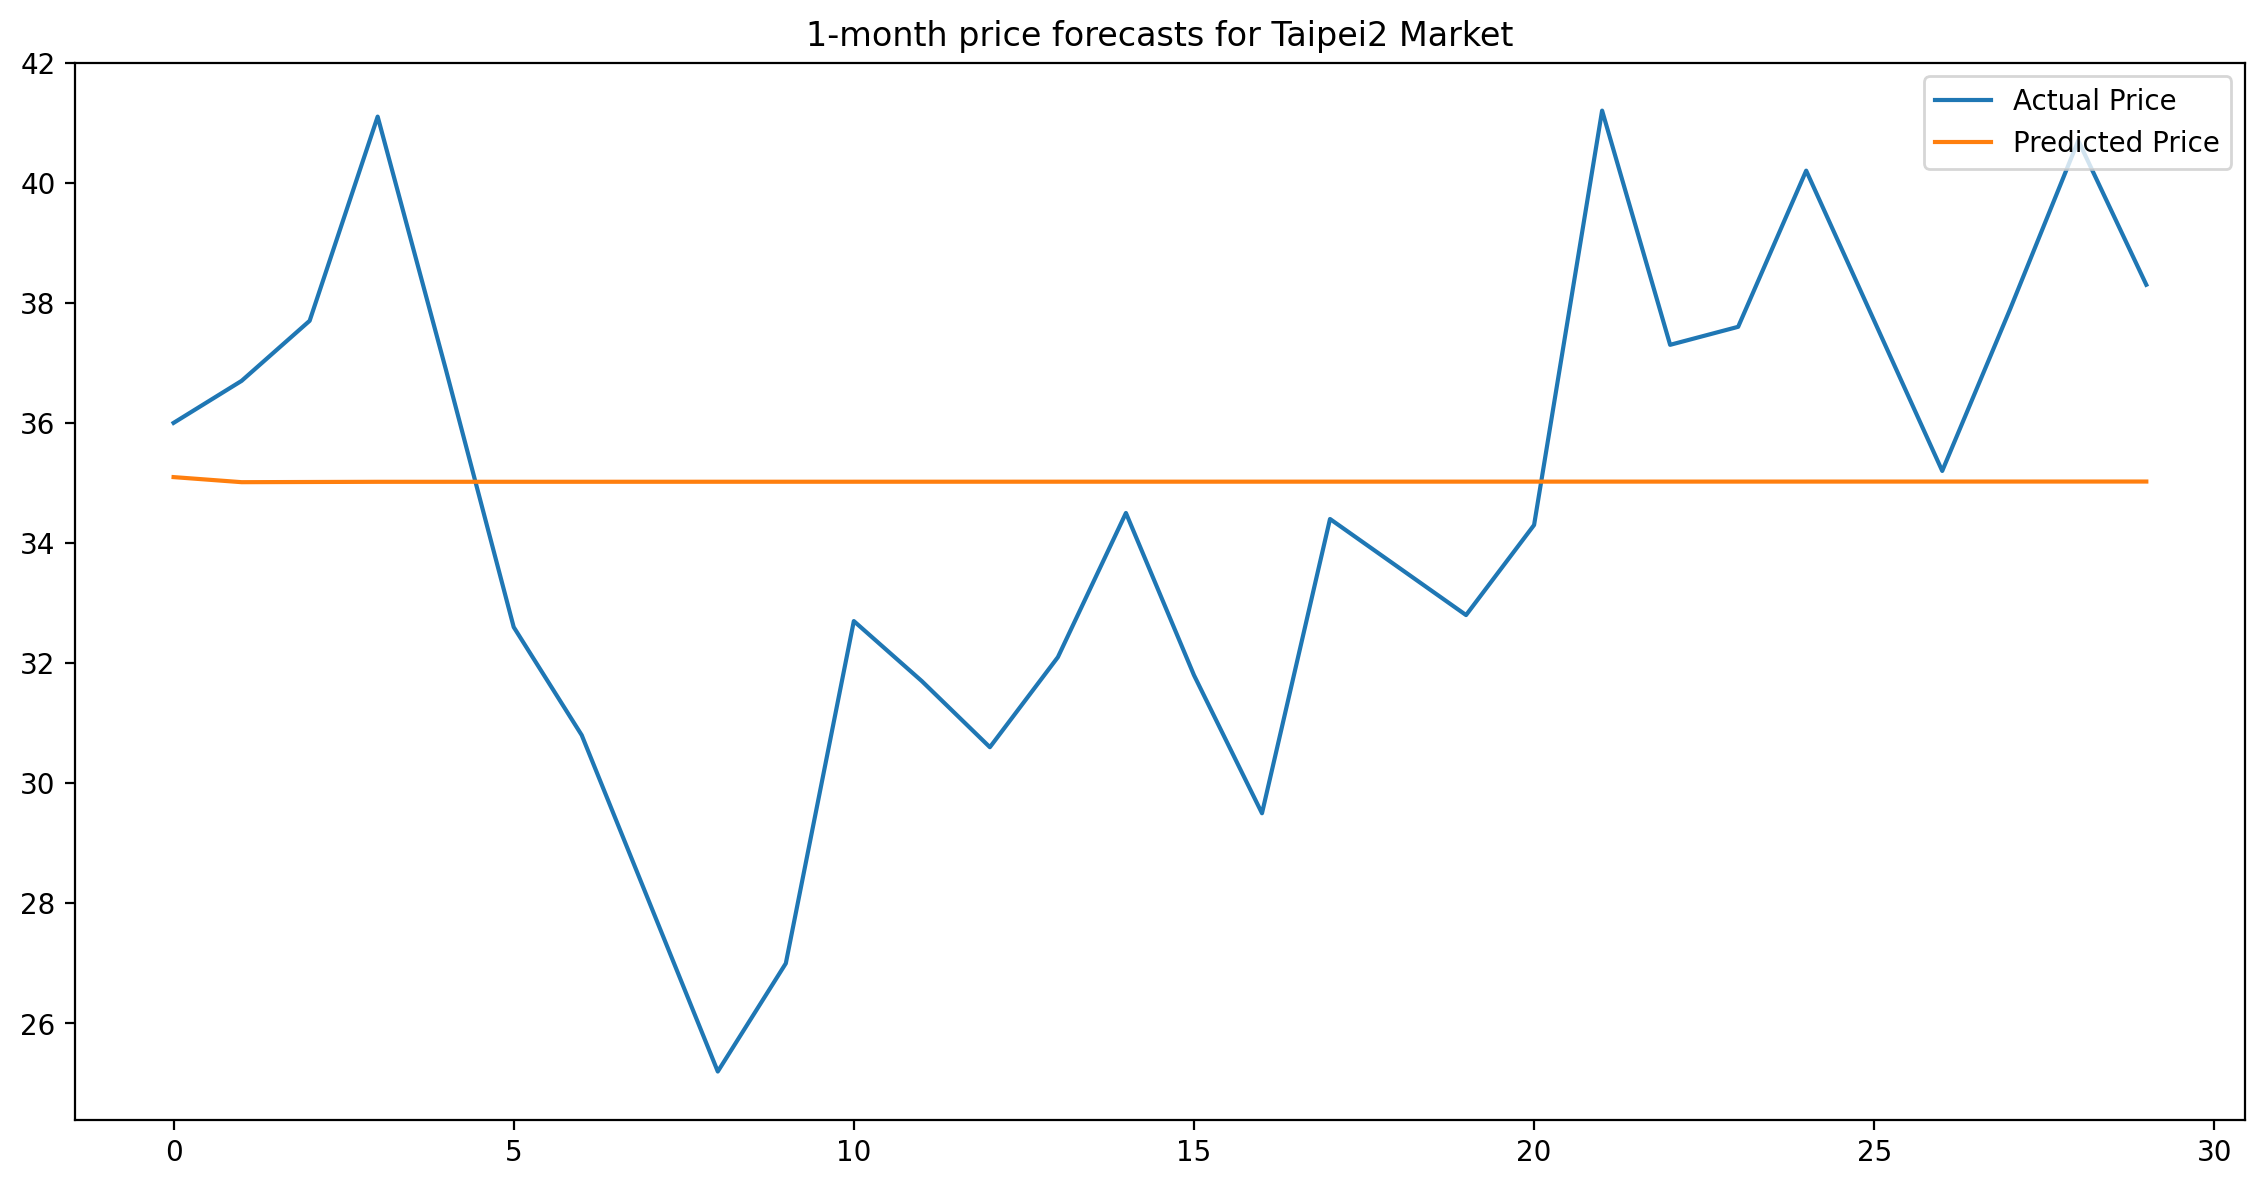

In [64]:
from statsmodels.tsa.stattools import acf
# from statsmodels.tsa.arima.model import ARIMA


# Create Training and Test
train = df.banana_平均價[:-30]
test = df.banana_平均價[-30:]

for i in range(len(test)):
# Build Model
# model = ARIMA(train, order=(3,2,1))  
    model = ARIMA(train, order=(3, 0, 1))  
    fitted = model.fit(disp=0)  

    # Forecast
    fc, se, conf = fitted.forecast(30, alpha=0.05)  # 95% conf
    

    # # Make as pandas series
#     fc_series = pd.Series(fc, index=test.index)
    fc_series = pd.Series(fc,index=test_2.index)

print(fc)
# Plot
plt.figure(figsize=(14,7), dpi=200)
# plt.plot(train, label='training')
plt.plot(test_2, label='Actual Price')
plt.plot(fc_series, label='Predicted Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
plt.title('1-month price forecasts for Taipei2 Market')
plt.legend(loc='upper right', fontsize=10)
plt.show()


In [69]:
plt.savefig('C:/Users/Tibame_T14/Desktop/簡報使用圖片/香蕉台北2.jpg')#儲存圖片

<Figure size 1200x360 with 0 Axes>

In [65]:
#RMSE
from math import sqrt
RMSE = sqrt(mean_squared_error(test_2, fc_series))
print(RMSE)

4.138410864918501


In [66]:
#MAPE
def mape(test, predictions):
    return np.mean(np.abs((fc_series - test_2) / test)) * 100

In [67]:
MAPE = mape(test_2, fc_series)
print(MAPE)

10.463479547482603


In [68]:
#MAD
MAD = sum (abs(test_2-fc_series))/len(test_2)
MAD

3.4287440797613677